### (project task 5 - goal 1) Build visualizations of fraud by dollar amount
1. bar chart containing counts of fraud transactions (y-axis) and transaction amounts (x-axis)
2. box plot comparing distribution of transaction amounts for fraud and non-fraud transactions.

### (project task 6 - goal 1) Write up analysis of fraud by dollar amount

### (project task 7 - goal 1) Perform a one-sample exact test of a population proportion
compare low dollar and higher dollar fraud
need to bootstrap?

### (project task 2 - goal 2) Build a bootstrap sample of fraud transactions

### project task 3 - goal 2) Build an analysis using test? to measure extent of differences between fraud and non-fraud samples for each feature

### (project task 4 - goal 2) Build a visualization comparing the difference in fraud non-fraud for each feature
bar graph with diff on y-axis and features on x-axis with sort form most to least difference

### (project task 8 - goal 3) - does fraud on day 2 distribution look like fraud on day 1
does legit on day 2 look like legit on day 1  
questions:
- measure using same strategy as measuring high vs. low dollar fraud?
- Do I need to look at each feature and see if there are major differences?

### (project task 9 - closure) - write up of high level recommendations for building fraud detection model

# Capstone 1: Fraud Detection Model Planning

Managing the costs associated with credit card fraud is critical for merchant success. A precision-recall balance must be maintained between identifying and addressing fruad and limiting the impact on legitimate customers. This project focuses on the planning steps for creating a credit card fraud detection model that can be utilized by merchants to identify fraud and determine this balance.

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains 28 potential fraud prediction features which have been anomynized through a PCA dimensionality reduction transformation in order to maintain confidentiality of the data. 

This project has three goals:
1.  Determine if multiple models are needed for detecting different variations of fraud.
2.  Identify features that are most likely to influence a fraud detection model.
3.  Estimate if training a model on Day 1 data will be sufficient for detecting fraud on Day2.

In [2]:
import helpers as h
import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
data = pd.read_csv("data/creditcard.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# data['Date'] = pd.Timestamp('2013-09-01 00:00:00') + data['Time'].apply(pd.offsets.Second)

In [6]:
Features = ['V%d' % n for n in range(1, 29)]
data = data[['Class', 'Amount', 'Time'] + Features]

In [7]:
data.head()

,Class,Amount,Time,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0,149.62,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,0,2.69,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,0,378.66,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,0,123.50,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,0,69.99,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


### task 1 - intro) Build Dataset Overview Visialization

In [8]:
# create a timeseries dataframe with Amount data called trends
trends = data[['Time','Amount','Class']]
trends['TimeSeries'] = pd.to_datetime(trends.Time, unit='s', origin='2013-09-01')
trends.set_index('TimeSeries', drop=False, inplace=True)

/Users/allanalberts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
fraud = trends[(trends.Class==1)][['Amount']].resample('H').count().dropna()
fraud.columns = ['Trans_cnt']
legit = trends[(trends.Class==0)][['Amount']].resample('H').count().dropna()
legit.columns = ['Trans_cnt']

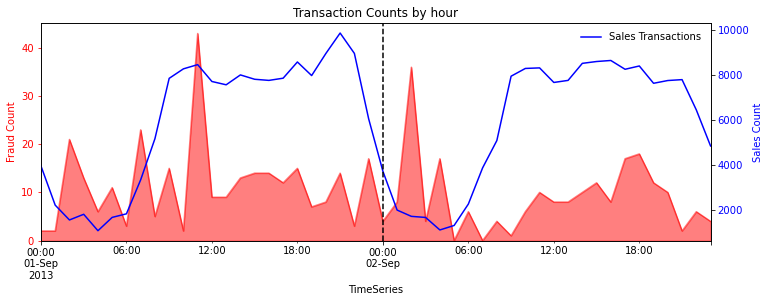

In [10]:
fig, ax = plt.subplots(figsize = (12,4))
fraud['Trans_cnt'].plot(color='r', kind='area', alpha=0.5, label='Fraud Transactions')
legit['Trans_cnt'].plot(secondary_y=True, color='b', label='Sales Transactions')
ax.set_ylabel('Fraud Count', color='r');
ax.tick_params(axis='y', colors='red')
plt.ylabel('Sales Count', color='b');
plt.yticks(color='b')
plt.axvline(x='2013-09-02 00:00:00', color='black', linestyle='dashed')
plt.legend(frameon=False, loc='upper right');
plt.title('Transaction Counts by hour', color='black');
plt.savefig('intro_fig.png')

### EDA: Amount Field (fraud vs non-fraud)

In [11]:
data.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


[(0.0, 20.0)]

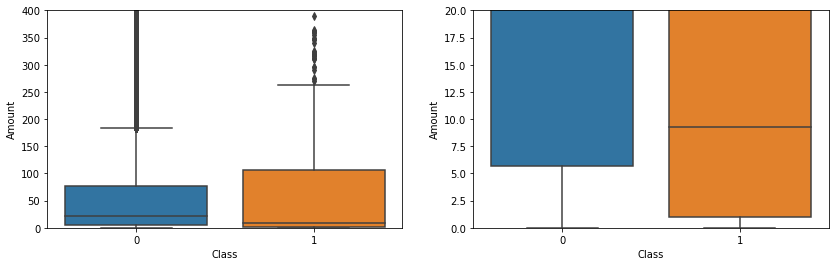

In [12]:
fig, axs = plt.subplots(1,2, figsize=(14,4))
sns.boxplot(ax=axs[0], x="Class", y="Amount", data=data)
axs[0].set(ylim=(0, 400))
axs[0].set_xticklabels({0:'Non-Fraud', 1:'Fraud'})
axs[0].xticklabels=['Non-Fraud', 'Fraud']

sns.boxplot(ax=axs[1], x="Class", y="Amount", data=data)
axs[1].set(ylim=(0, 20))

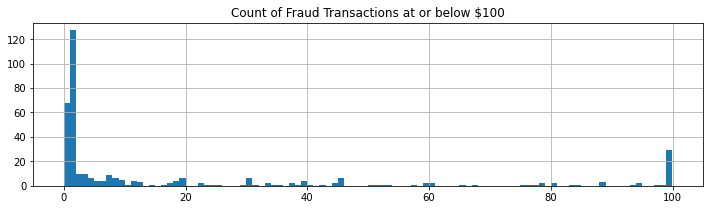

In [13]:
fig, ax = plt.subplots(figsize=(12,3))
data[(data['Class']==1) & (data['Amount']<=100)]['Amount'].hist(bins=100)
_ = ax.set_title("Count of Fraud Transactions at or below $100")

### Time Series Graph

In [14]:
data.groupby('Class')[['V1']].count()

,V1
Class,
0,284315
1,492


In [15]:

data[data['Class']==1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [16]:
data[data['Class']==0]['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
# make new boolean fields that are fraud and non-fraud and use describe on them to compare quartiles in one frame

<AxesSubplot:>

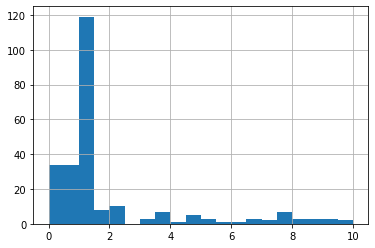

In [18]:
data[(data['Class']==1) & (data['Amount']<10)]['Amount'].hist(bins=20)

<AxesSubplot:>

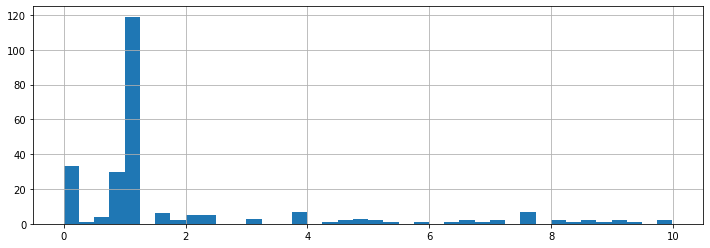

In [19]:
data[(data['Class']==1) & (data['Amount']<=10)]['Amount'].hist(bins=40, figsize=(12,4))

In [20]:
data[(data['Amount']<2)]['Amount'].count()

46990

In [21]:
data[(data['Class']==1) & (data['Amount']<2)]['Amount'].count()

195

In [22]:
data['Amt Group'] = np.where(data['Amount']>1,'High','Low') 

In [23]:
print(f"Low dollar fraud rate: {data[data['Amt Group']=='Low']['Class'].mean()}")
print(f"High dollar fraud rate: {data[data['Amt Group']=='High']['Class'].mean()}")

Low dollar fraud rate: 0.005935983208710482
High dollar fraud rate: 0.0012228928690796847


In [24]:
HighDollarFraudRate = 0.0012228928690796847
binomial = stats.binom(46990, 0.0012228928690796847)
print(1-binomial.cdf(195))


1.1102230246251565e-16


In [37]:
#         age_group_1_ctr = df_signed_in[df_signed_in.age_groups == age_group_1]['CTR']
#         age_group_2_ctr = df_signed_in[df_signed_in.age_groups == age_group_2]['CTR']
#         p_value = stats.ttest_ind(age_group_1_ctr, age_group_2_ctr, equal_var=True)[1]

In [39]:
non_fraud_grp_v1.head()

0    0.098698
1    0.085102
2    0.247676
3    0.377436
4   -0.270533
Name: V8, dtype: float64

In [40]:
data.groupby('Class')[['V1']].count()

,V1
Class,
0,284315
1,492


In [30]:
data['Date'] = pd.to_datetime(data['Time'])

In [31]:
data[['Time','Date']].tail()

,Time,Date
284802,172786.0,1970-01-01 00:00:00.000172786
284803,172787.0,1970-01-01 00:00:00.000172787
284804,172788.0,1970-01-01 00:00:00.000172788
284805,172788.0,1970-01-01 00:00:00.000172788
284806,172792.0,1970-01-01 00:00:00.000172792


In [32]:
data['Time'].agg(['min', 'max'])

min         0.0
max    172792.0
Name: Time, dtype: float64

In [33]:
data['Time'].max()/3600

47.99777777777778

In [59]:
fraud_grp_v1 = data[data['Class']==1]['V8']
non_fraud_grp_v1 = data[data['Class']==0]['V8']
#p_value = stats.ttest_ind(fraud_grp_v1, non_fraud_grp_v1, equal_var=True)[1]

stat, p_val = stats.ttest_ind(fraud_grp_v1, non_fraud_grp_v1, equal_var=True)
print('The statistic is: {} \nP-value: {}'.format(stat ,p_val))

stat, p_val = stats.ttest_ind(fraud_grp_v1, non_fraud_grp_v1, equal_var=False)
print('The statistic is: {} \nP-value: {}'.format(stat ,p_val))

The statistic is: 10.608877735555245 
P-value: 2.740673101247189e-26
The statistic is: 1.8651390657084321 
P-value: 0.06275811803424974


## Legitimate Transaction Sample

In [77]:
df_stat_legit = data[Features][data['Class']==0].agg(['mean', 'median', 'std'])
df_stat_legit.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
mean,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,...,-0.001178,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131
median,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,-0.091872,...,0.003117,-0.062646,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199
std,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,1.044204,...,0.811733,0.769404,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570


In [79]:
df_stat_fraud = data[Features][data['Class']==1].agg(['mean', 'median', 'std'])
df_stat_fraud.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
mean,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,...,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667
median,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,...,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344
std,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,...,1.539853,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291


In [84]:
df_stats_bsfraud['std'].sort_values()

V26    0.463163
V24    0.503166
V28    0.549976
V25    0.839411
V15    1.013896
V13    1.104677
V27    1.282430
V20    1.418168
V22    1.512449
V19    1.548579
V23    1.701482
V6     1.875997
V9     2.493573
V11    2.699170
V18    2.794441
V4     2.860302
V16    3.754265
V21    3.844509
V14    4.292641
V2     4.421698
V12    4.597813
V10    4.899248
V5     5.377127
V17    6.705965
V8     6.882861
V1     6.899323
V3     7.300050
V7     7.315723
Name: std, dtype: float64

## Bootstrap Fraud Sample

In [112]:
#import scikits.bootstrap as sci
df_fraud = data[Features][data['Class']==1]
df_bootstrap_mean = pd.DataFrame(columns=df_fraud.columns)
df_bootstrap_std = pd.DataFrame(columns=df_fraud.columns)
df_bootstrap_median = pd.DataFrame(columns=df_fraud.columns)

samples = 5000
for _ in range(samples):
    bootstrap = df_fraud.sample(n=len(df_fraud), replace=True, axis=0, random_state=1111)
    df_bootstrap_mean = df_bootstrap_mean.append(bootstrap.mean(), ignore_index=True)
    df_bootstrap_std = df_bootstrap_std.append(bootstrap.std(), ignore_index=True)
    df_bootstrap_median = df_bootstrap_median.append(bootstrap.median(), ignore_index=True)
bootstrap_mean = df_bootstrap_mean.mean()

bootstrap_mean.head()
# bootstrap_std = df_bootstrap_std.mean()
# bootstrap_median = df_bootstrap_median.mean()

V1   -4.679683
V2    3.496605
V3   -6.859388
V4    4.463743
V5   -2.956782
dtype: float64

In [114]:
bootstrap_mean


V1    -4.679683
V2     3.496605
V3    -6.859388
V4     4.463743
V5    -2.956782
V6    -1.387230
V7    -5.516175
V8     0.463973
V9    -2.526932
V10   -5.569530
V11    3.717819
V12   -6.001943
V13   -0.142305
V14   -6.813321
V15   -0.055208
V16   -3.962919
V17   -6.318586
V18   -2.103766
V19    0.633301
V20    0.437634
V21    0.471232
V22    0.063724
V23   -0.039214
V24   -0.120506
V25    0.046576
V26    0.047478
V27    0.278541
V28    0.067567
dtype: float64

In [103]:
def bootstrap(df, stat, samples=1000):
    '''Returns a series containing the mean bootstrap value of the statistic for each of the columns in the DataFrame.

    Parameters
    ----------
    df: pandas DataFrame
    stat: test statistic
    sample: number of bootstrap samples

    Returns
    -------
    pandas series'''
    
    for _ in range(samples):
        bootstrap = df.sample(n=len(df_fraud), replace=True, axis=0, random_state=1111)
        df_bootstrap = pd.DataFrame(columns=df.columns)
        df_bootstrap = df_bootstrap_mean.append(bootstrap.stat, ignore_index=True)
    
    return df_bootstrap_mean.mean()


In [111]:
class Bootstrap:

    def __init__(self, dataframe, size=500):
         """Create a Bootstrap object
        Parameters
        ----------
        dataframe : dataframe containing samples to bootstrap
        size: the number of bootstrap samples to perform
        """
        self.dateframe = dataframe
        self.size = size
        
    def mean(self, dataframe):
        '''create a dataframe containing the mean value of the means of the individual bootstrap samples'''
        df_bootstrap = pd.DataFrame(columns=self.dataframe.columns)
        for _ in range(self.samples):
            bootstrap = self.dataframe.sample(n=len(self.dataframe), replace=True, axis=0, random_state=1111)
            df_bootstrap = df_bootstrap.append(bootstrap.mean(), ignore_index=True)
        return df_bootstrap
        

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

In [109]:
x = Bootstrap(df_fraud, 500)
y = x.mean()
y.head()

NameError: name 'Bootstrap' is not defined

In [76]:
# create dataframe of bootstrap fraud and legit sample statistics
df_stats_bsfraud = pd.concat([bootstrap_mean, bootstrap_std, bootstrap_median], axis=1, sort=False)
df_stats_bsfraud.columns = ['mean', 'std', 'median']
print(df_stats_bsfraud.transpose())

              V1        V2        V3        V4        V5        V6        V7  \
mean   -4.679683  3.496605 -6.859388  4.463743 -2.956782 -1.387230 -5.516175   
std     6.899323  4.421698  7.300050  2.860302  5.377127  1.875997  7.315723   
median -2.140511  2.571398 -4.764455  4.113823 -1.597509 -1.434471 -3.034402   

              V8        V9       V10  ...       V19       V20       V21  \
mean    0.463973 -2.526932 -5.569530  ...  0.633301  0.437634  0.471232   
std     6.882861  2.493573  4.899248  ...  1.548579  1.418168  3.844509   
median  0.626857 -2.081997 -4.624985  ...  0.605539  0.313332  0.573898   

             V22       V23       V24       V25       V26       V27       V28  
mean    0.063724 -0.039214 -0.120506  0.046576  0.047478  0.278541  0.067567  
std     1.512449  1.701482  0.503166  0.839411  0.463163  1.282430  0.549976  
median  0.033922 -0.050619 -0.061263  0.109192  0.000308  0.429896  0.163177  

[3 rows x 28 columns]


ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

In [46]:
print(bootstrap_mean)
print(df_fraud.mean())

V1    -4.679683
V2     3.496605
V3    -6.859388
V4     4.463743
V5    -2.956782
V6    -1.387230
V7    -5.516175
V8     0.463973
V9    -2.526932
V10   -5.569530
V11    3.717819
V12   -6.001943
V13   -0.142305
V14   -6.813321
V15   -0.055208
V16   -3.962919
V17   -6.318586
V18   -2.103766
V19    0.633301
V20    0.437634
V21    0.471232
V22    0.063724
V23   -0.039214
V24   -0.120506
V25    0.046576
V26    0.047478
V27    0.278541
V28    0.067567
dtype: float64
V1    -4.771948
V2     3.623778
V3    -7.033281
V4     4.542029
V5    -3.151225
V6    -1.397737
V7    -5.568731
V8     0.570636
V9    -2.581123
V10   -5.676883
V11    3.800173
V12   -6.259393
V13   -0.109334
V14   -6.971723
V15   -0.092929
V16   -4.139946
V17   -6.665836
V18   -2.246308
V19    0.680659
V20    0.372319
V21    0.713588
V22    0.014049
V23   -0.040308
V24   -0.105130
V25    0.041449
V26    0.051648
V27    0.170575
V28    0.075667
dtype: float64


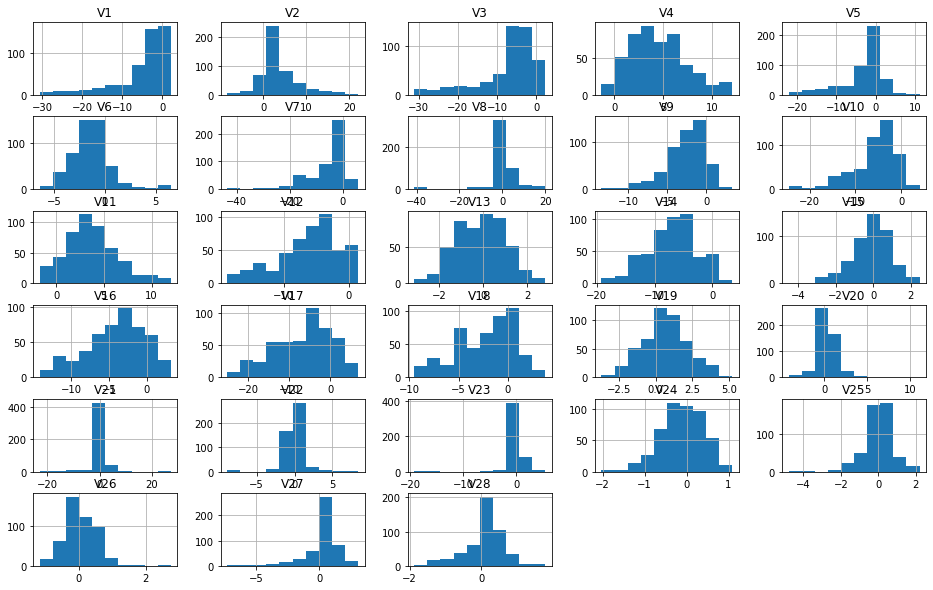

In [57]:
df_fraud.hist(figsize = (16,10))
plt.show()

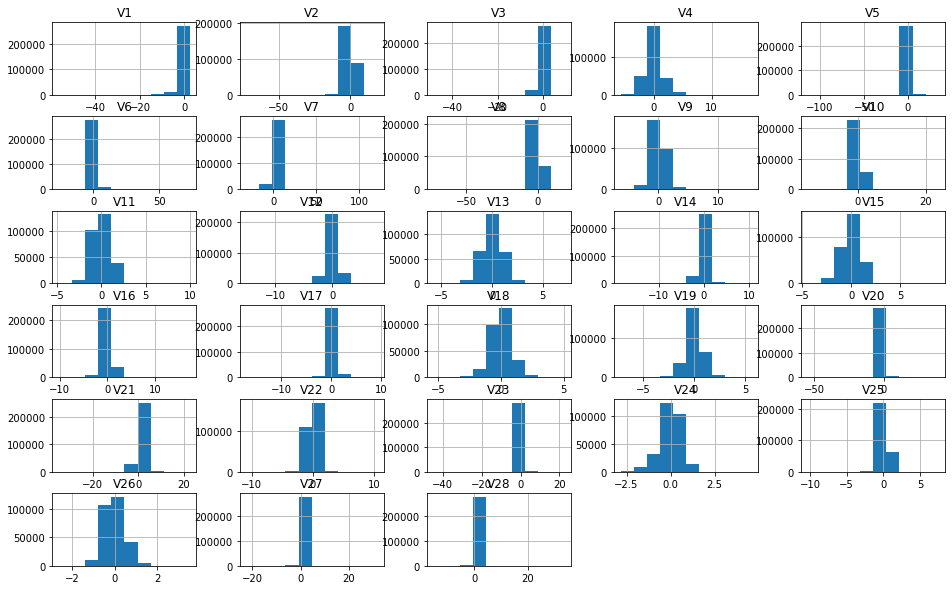

In [58]:
df_legit = data[Features][data['Class']==0]
df_legit.hist(figsize = (16,10))
plt.show()

# Initial Capstone Proposal
Capstone 1: Credit Card Fraud Detection - Part 1

The data set is highly imbalanced containing 492 fraud transaction and 284K non-fraud transactions. This is similar to real world fraud data. I will **bootstrap** the fraud transaction samples to obtain a better description of the fraud population which will then be used to compare fraud detection features against the non fraud sample with a goal of identifying the features that are least similar between the datasets. These features can then be used in a second Capstone to predict the likelihood of fraud. I will compare features between the fraud and non-fraud groups utilizing **non parametric t-tests**.

The dataset contains time, amount and 28 individual transaction features for 284,807 credit card transactions that occurred over a 2 day period of time. The transactions features in the dataset have been anomynized using PCA so there is no 'real world' intuition or bias that can be brought to analysis of the effectiveness of using these features to predict fraud. However, some relevant insight can be gained from the amount field.

A cursory analysis of the fraud sample shows that 25% of the fraud transactions are at or below one dollar. Transactions at this low dollar level are serving a separate fraud purpose than the higher dollar transactions. These low dollar transaction are not being effectively monitized, but rather simply testing the ability of the credit card to be used in a larger fraud. I will use a **one-sample exact test of a population proportion** to deterine if their exists a statistical difference in the mean fraud rates between the transactions that are equal to or less than one dollar and those that are above that amount. If a difference is found, then I may consider splitting the data into two groups for separate predictive analysis in Capstone 2 as they are related to different types of fraudulent behavior. 

### notes for me:
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project